In [1]:
# Imports libraries for tiff loading, analyusis, and plotting
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.ndimage import label
from skimage.measure import block_reduce
plt.style.use('Jlab2.mplstyle')

In [2]:
# Loads the raw tiff file as a stacked numpy array (frames x width in pixels x height in pixels)
tif_stack = tiff.imread('path to raw data tif file') 

# Loads the mask (a binary image) and convert it to a boolean array
mask = tiff.imread('path to mask for raw data tif file').astype(bool)

(-0.5, 29.5, 29.5, -0.5)

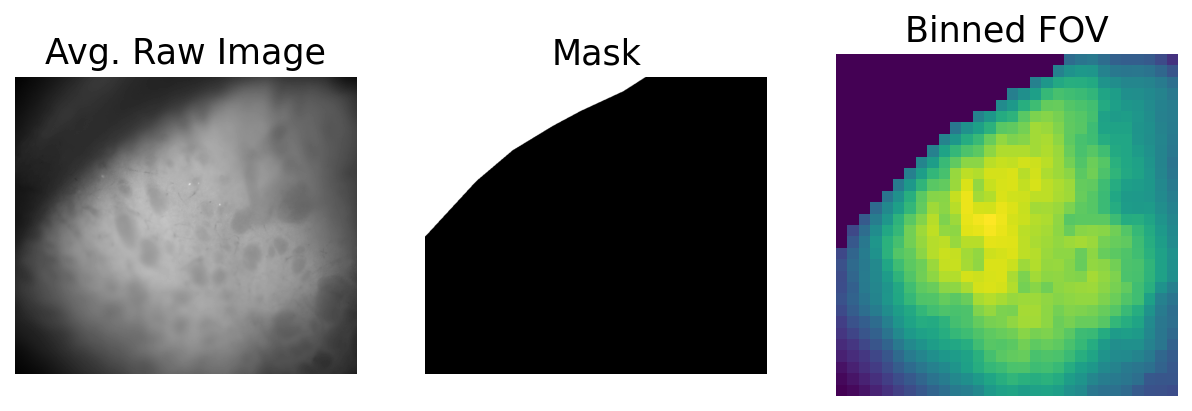

In [43]:
# Sets the number of spatial bins to segment x and y axes 
bin_no = 30

# Applies the mask to set all masked pixels to NaN
tif_stack_masked = np.where(mask, np.nan, tif_stack)

#  Defines bins along Y and X
num_bins_y, num_bins_x = bin_no, bin_no

# Computes bin size (pixels per bin in Y & X)
bin_size_y, bin_size_x = tif_stack_masked.shape[1] // num_bins_y, tif_stack_masked.shape[2] // num_bins_x

# Computes cropped height and width
cropped_height, cropped_width = bin_size_y * num_bins_y, bin_size_x * num_bins_x

# Crops the stack to divisible dimensions
cropped_stack = tif_stack_masked[:, :cropped_height, :cropped_width]

# Bins the stack using block averaging 
binned_stack = block_reduce(
    cropped_stack, 
    block_size=(1, bin_size_y, bin_size_x), 
    func=np.nanmean)

# Identifies masked bins
binned_mask = block_reduce(
    mask[:cropped_height, :cropped_width], 
    block_size=(bin_size_y, bin_size_x), 
    func=np.nanmax)

# Sets masked bins to NaN
binned_stack[:, binned_mask == 1] = np.nan

# Computes the minimum nonNaN bin value
min_bin_value = np.nanmin(np.mean(binned_stack, axis=0))

# Replaces NaN values with the minimum value
binned_stack = np.nan_to_num(binned_stack, nan=min_bin_value)

fig, ax = plt.subplots(1,3, figsize=(10, 10))
# Plots the average projection of the raw tiff file across the full recording
ax[0].imshow(np.mean(tif_stack, axis=0), cmap='gray')
ax[0].set(title='Avg. Raw Image')
ax[0].axis('off')

# Plots the mask to show the area(s) excluded from subsequent analyses
ax[1].imshow(mask, cmap='gray')
ax[1].set(title='Mask')
ax[1].axis('off')

# Plots mean activity across the binned FOV
img = ax[2].imshow(np.mean(binned_stack, axis=0), cmap='viridis', aspect='auto')
ax[2].set_title('Binned FOV')
ax[2].set(xlabel='Bin', ylabel='Bin')
ax[2].set_aspect('equal')
ax[2].axis('off')

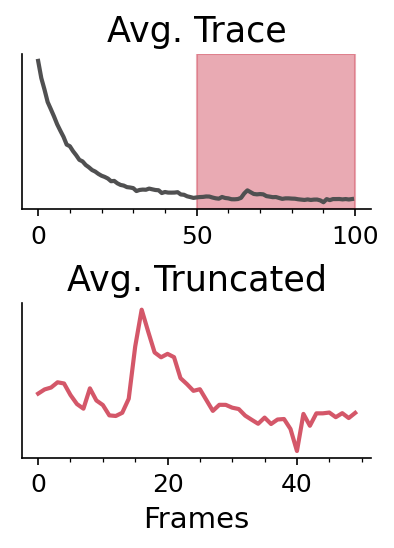

In [70]:
# Excludes the first n frames of data (i.e. exponential decay artefact) 
excluded_frames = 50
trunc_stack = binned_stack[excluded_frames:]

fig, ax = plt.subplots(2,1, figsize=(3,3.5))
ax[0].plot(binned_stack.mean(axis=(1,2)), linewidth=2)
ax[0].axvspan(excluded_frames, len(tif_stack), color='C1', alpha=0.5)
ax[0].get_yaxis().set_visible(False)
ax[0].set(title='Avg. Trace')

ax[1].plot(trunc_stack.mean(axis=(1,2)), color='C1', linewidth=2)
ax[1].get_yaxis().set_visible(False)
ax[1].set(title='Avg. Truncated', xlabel='Frames')

plt.subplots_adjust(hspace=0.6)

In [46]:
def sliding_dff(trunc_stack, window_size=100, percentile=8):
    """
    Calculate ΔF/F using a sliding window with a specified percentile.

    Parameters:
        trunc_stack (np.ndarray): 3D array of fluorescence data (frames, height, width).
        window_size (int): Number of frames in the sliding window (ensure longer than events).
        percentile (float): Percentile to calculate F₀ in each window.
    
    Returns:
        dff_stack (np.ndarray): ΔF/F normalized fluorescence data for each bin.
    """
    # Initialises F0 array
    F0_sliding = np.empty_like(trunc_stack)

    # Iterates over frames
    for frame in range(trunc_stack.shape[0]):
        # Defines the start and end of the window
        start_frame = max(0, frame - window_size)
        end_frame = min(trunc_stack.shape[0], frame + window_size)

        # Calculates the percentile for F0 (ignoring NaNs)
        F0_sliding[frame] = np.nanpercentile(
            trunc_stack[max(0, frame - window_size):max(1, frame)], percentile, axis=0
        )

    # Calculates ΔF/F
    dff_stack = (trunc_stack - F0_sliding) / F0_sliding
    
    return dff_stack

dff_stack = sliding_dff(trunc_stack)

# Gets the dimensions of the dff stack (frames, height, width)
_, binned_height, binned_width = dff_stack.shape

# Generates a list of all bin coordinates
bins = [(y, x) for y in range(binned_height) for x in range(binned_width)]

# The cell you'll work on

In [66]:
def detect_events(dff_stack, bins, filter_window=5, prominence=5, min_event_length=5, 
                  filter_polyorder=2, threshold=5, min_distance=2, frame_rate=10, percentile=90):

    aligned_events = []    # Creates a list to store merged (aligned) events
    all_event_frames = []  # Creates a list to store the frames of detected events

    for bin_coords in bins:
        y, x = bin_coords
        trace = dff_stack[:, y, x]  # Extracts ΔF/F trace for this specific bin
        
        # Smooths the trace using a Savitzky-Golay filter
        smoothed_trace = savgol_filter(trace, window_length=int(filter_window), polyorder=filter_polyorder)
        
        # Computes percentile threshold and noise estimate (sigma via MAD)
        percentile_threshold = np.nanpercentile(smoothed_trace, percentile)
        mad = np.nanmedian(np.abs(smoothed_trace - np.nanmedian(smoothed_trace))) + 1e-12
        sigma = 1.4826 * mad
        
        # Detects peaks above threshold with required prominence and spacing
        peaks, _ = find_peaks(smoothed_trace, 
                              height=threshold * sigma,
                              prominence=prominence * sigma,
                              distance=min_distance)

        # Identifies event start/end around each peak
        for peak in peaks:
            start = peak                            # Search bakcward to event onset
            while start > 0 and smoothed_trace[start - 1] > percentile_threshold:
                start -= 1
            end = peak                              # Search forward to even offset
            while end < len(smoothed_trace) - 1 and smoothed_trace[end + 1] > percentile_threshold:
                end += 1
            if (end - start) >= min_event_length:   # Store only sufficiently long events
                all_event_frames.append((peak, start, end, bin_coords))

    # Sort all detected events by peak frame
    all_event_frames.sort(key=lambda x: x[0])  
    
    aligned_events = []  # Creates a list to store merged (aligned) events
    
    for peak_frame, start, end, bin_coords in all_event_frames:
        # Stores the details of the first event
        if not aligned_events:
            aligned_events.append({
                'start': int(start),
                'end': int(end),
                'bins': [bin_coords],
                'peak': int(peak_frame)  
            })
            continue

        last = aligned_events[-1]   # Most recent grouped event
        frame_range = 10            # Merge events whose peaks occur within ±10 frames
        if abs(peak_frame - last['peak']) <= frame_range:
            last['start'] = int(min(last['start'], start))   # Extend event start if needed
            last['end']   = int(max(last['end'], end))       # Extend event end if needed
            last['bins'].append(bin_coords)                  # Add contributing bin
        else:
            # Stores a new event
            aligned_events.append({
                'start': int(start),
                'end': int(end),
                'bins': [bin_coords],
                'peak': int(peak_frame)
            })

    return aligned_events

aligned_events = detect_events(dff_stack, bins, filter_window=5, min_event_length=1, 
                               prominence=6, threshold=5, min_distance=1, percentile=50)



### TO DO ### 
# - Add a spatial component to even detection (i.e. align events which are connected to neighbouring bins

In [67]:
def get_max_bins(aligned_events, filter_window=5, min_event_length=1, 
                 prominence=6, threshold=5, min_distance=1, percentile=50, 
                 filter_polyorder=2):
    # ===== plotting (uses event['peak'] to draw a vertical line) =====
    max_bin_events = []
    
    for event in aligned_events:
        event_start = event['start']
        event_end = event['end']
    
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
        avg_image = np.nanmax(dff_stack[event_start:event_end+1], axis=0)
        min_bin_value = np.nanmin(avg_image)
        avg_image = np.nan_to_num(avg_image, nan=min_bin_value)
        avg_image[avg_image == min_bin_value] = np.nanmin(avg_image[avg_image > min_bin_value])
        img = ax[1].imshow(avg_image, cmap='viridis', aspect='auto', vmin=(np.nanmin(avg_image)) * 9, vmax=np.nanmax(avg_image))
        plt.colorbar(img, ax=ax[1], label='ΔF/F₀')
        max_heatmap_coords = np.unravel_index(np.nanargmax(avg_image), avg_image.shape)
        ax[1].scatter(max_heatmap_coords[1], max_heatmap_coords[0], color='indianred', label="Selected Bin")
        ax[1].set_title(f"Event Max Intensity (Frames {event_start}:{event_end})")
        ax[1].set_xlabel("Binned X")
        ax[1].set_ylabel("Binned Y")
    
    
        y, x = max_heatmap_coords
        trace = dff_stack[:, y, x]
        smoothed_max_trace = savgol_filter(trace, window_length=int(filter_window), polyorder=filter_polyorder)
        percentile_threshold = np.nanpercentile(smoothed_max_trace, percentile)
        mad = np.nanmedian(np.abs(smoothed_max_trace - np.nanmedian(smoothed_max_trace))) + 1e-12
        sigma = 1.4826 * mad
    
        # detect and store fram at which peaks occur, in an array called 'peaks'
        peaks, props = find_peaks(smoothed_max_trace, 
                              height=threshold * sigma,
                              prominence=prominence * sigma,
                              distance=min_distance)
    
        # for every detected peak, find where the signal starts and ends
        for peak in peaks:
            # starting at the peak, move backwards in frames until the signal drops below a chosen baseline
            max_start = peak
            while max_start > 0 and smoothed_max_trace[max_start - 1] > percentile_threshold:
                max_start -= 1
            # starting at the peak, move foreards in frames until the signal drops below a chosen baseline
            max_end = peak
            while max_end < len(smoothed_max_trace) - 1 and smoothed_max_trace[max_end + 1] > percentile_threshold:
                max_end += 1
            max_start = max_start - 1   ### Hard coded since optimal detection was off by 1 frame
            max_end = max_end + 1   ### Hard coded since optimal detection was off by 1 frame
        

    
        max_bin_events.append({
            "event_start": max_start,
            "event_end": max_end,
            "bin": (y, x),
            "peak frame": max_start + np.argmax(smoothed_max_trace[max_start:max_end])
        })
    
    
    # max_event_frames
    
        ax[0].plot(smoothed_max_trace, color='C2', linewidth=4, label='Smoothed ΔF/F₀', zorder=1)
        ax[0].axvline((max_start + np.argmax(smoothed_max_trace[max_start:max_end])), color='C2', linewidth=2, linestyle='--')
        ax[0].axvspan(max_start, max_end, color='C2', alpha=0.4)
        ax[0].axhline(threshold * sigma, color='gray', linestyle='--', label='Threshold', zorder=2)
        ax[0].axhline(percentile_threshold, color='green', linestyle='--', label=f'{percentile}th Percentile', zorder=2)
    

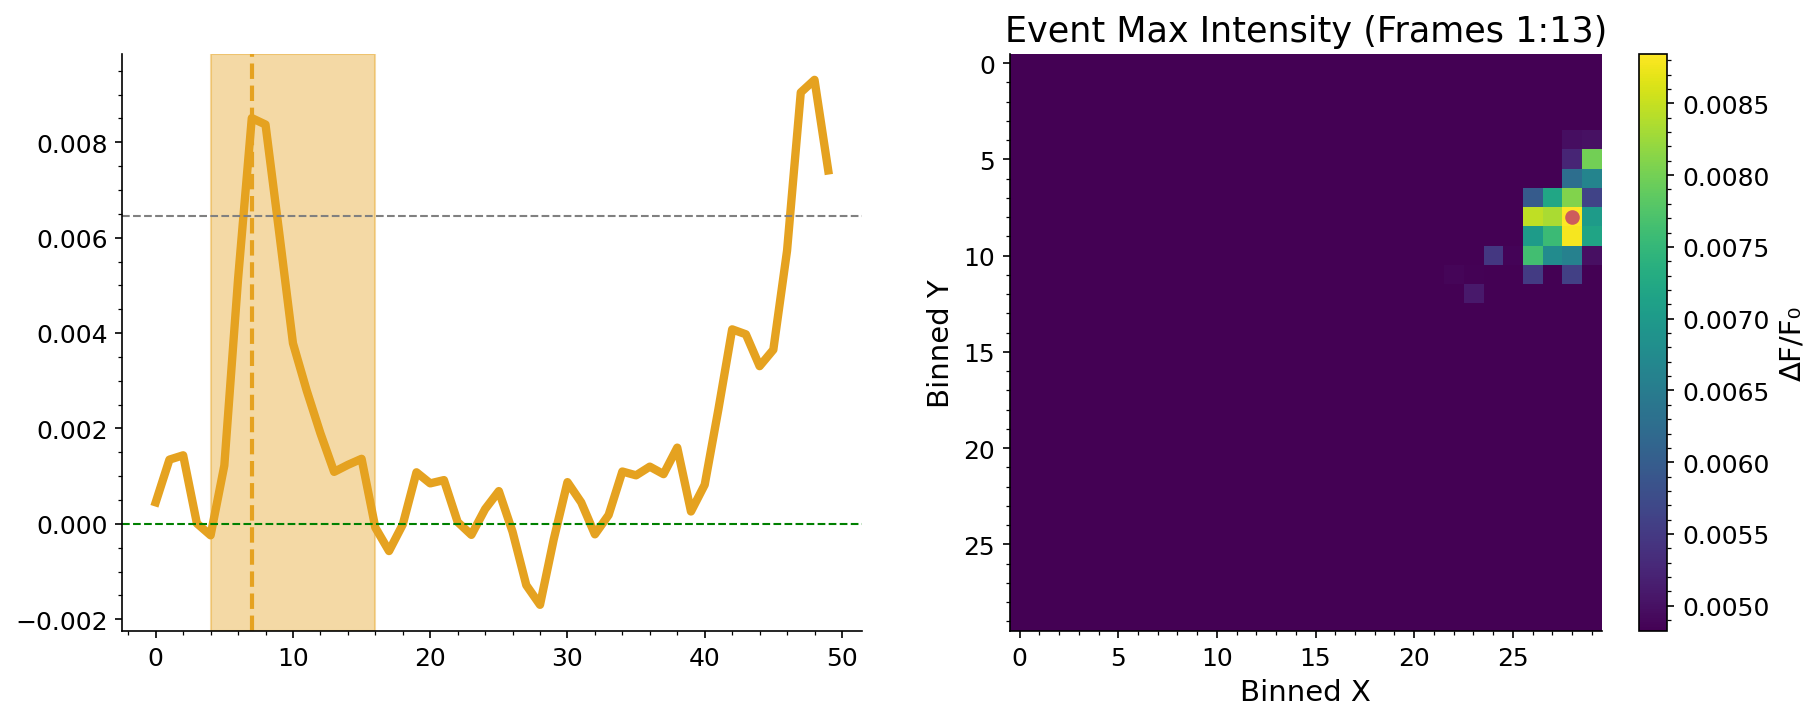

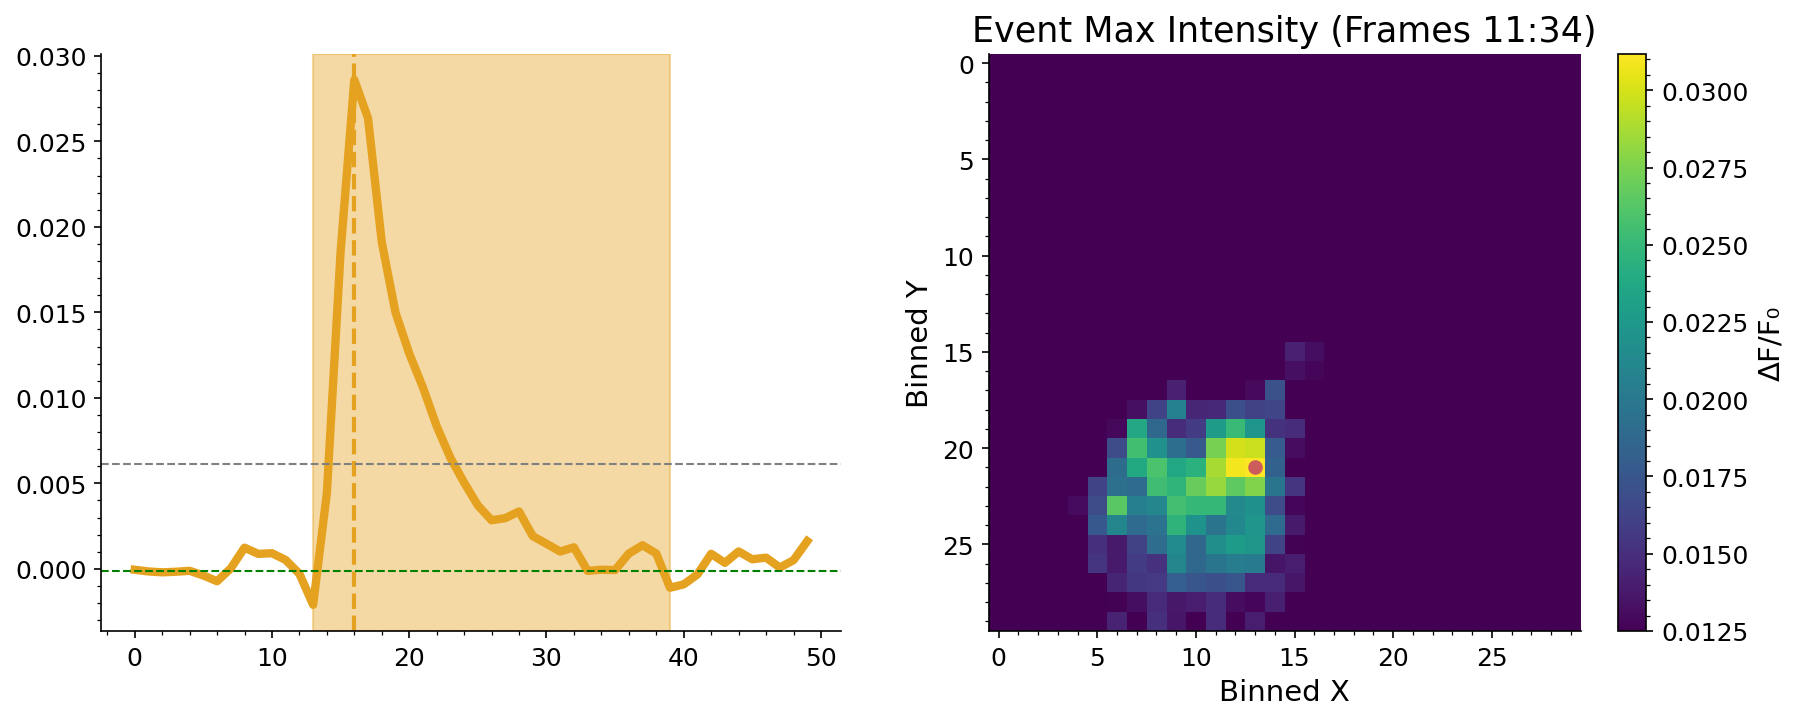

In [68]:
get_max_bins(aligned_events, filter_window=5, min_event_length=1, 
                 prominence=5, threshold=4, min_distance=1, percentile=20, 
                 filter_polyorder=2)